In [1]:
from poisson_equation.trainer import DGMTrainerPE, DGMTrainerPE_2D
from poisson_equation.utility_functions import *
from poisson_equation.data_sampling import *
import poisson_equation_network as network
from poisson_equation.visualize import *
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Deep Galerkin Method with Poisson Equation in 1D (Time Independent)

In [2]:
lx_1d = 2.0
bounds_1d = [[0.0, lx_1d]]

# PDE Constants (For Poisson Equation )

# Data Sizes
N_INT = 1500
N_BC =400


## Data Preparation

In [3]:
# 1. Domain Data (x in [0, lx_1d])
x_int = generate_domain_points(N_INT, bounds_1d)
#print("Internal domain points ",x_int)
f_x = source_term_fn_1D(x_int).to(device)
domain_data = (x_int, f_x)

# 2 Boundary Points
c_bc = generate_bc_points(N_BC, bounds_1d)
u_bc = boundary_condition_fn_1D(c_bc).to(device)
bc_data = (c_bc, u_bc)

## Visualization of the generated Data Points

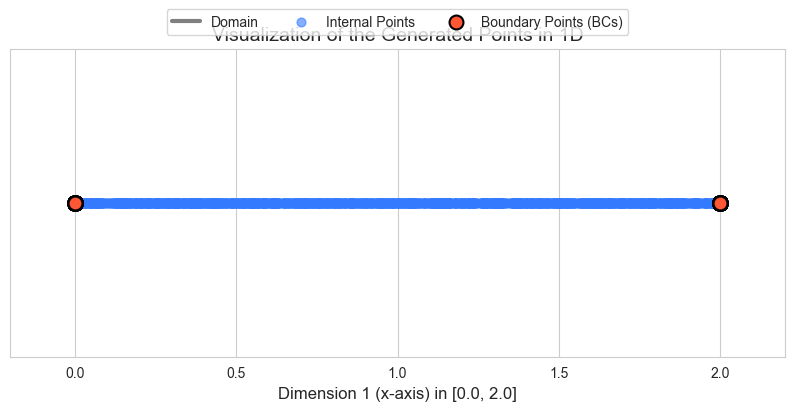

In [4]:
visualize_points_1d(x_int,c_bc, bounds_1d)

## Network Initialization

In [5]:
num_layers = 5
nodes_per_layer = 64
learning_rate = 0.001
epochs = 1000

model = network.DGMNet(nodes_per_layer, num_layers, 1).to(device)
trainer = DGMTrainerPE(
    model=model,
    learning_rate=learning_rate
)

## Training

In [6]:
trainer.train(
    epochs=epochs,
    domain_data=domain_data,
    bc_data=bc_data,
    lambda_pde=50.0,
    lambda_bc=50.0,
    resample=True,
    sampling_config={
        'n_int': N_INT,
        'n_bc': N_BC,
        'bounds': bounds_1d
    }
)

Starting training on mps. Interior: 1500, BC: 400 points.
Epoch 100/1000 | Total Loss: 15.4949 | L_pde: 0.2196 | L_bc: 0.0903
Epoch 200/1000 | Total Loss: 0.7374 | L_pde: 0.0147 | L_bc: 0.0000
Epoch 300/1000 | Total Loss: 0.1880 | L_pde: 0.0038 | L_bc: 0.0000
Epoch 400/1000 | Total Loss: 0.0669 | L_pde: 0.0013 | L_bc: 0.0000
Epoch 500/1000 | Total Loss: 0.0440 | L_pde: 0.0009 | L_bc: 0.0000
Epoch 600/1000 | Total Loss: 0.0335 | L_pde: 0.0007 | L_bc: 0.0000
Epoch 700/1000 | Total Loss: 0.0258 | L_pde: 0.0005 | L_bc: 0.0000
Epoch 800/1000 | Total Loss: 0.0198 | L_pde: 0.0004 | L_bc: 0.0000
Epoch 900/1000 | Total Loss: 0.0151 | L_pde: 0.0003 | L_bc: 0.0000
Epoch 1000/1000 | Total Loss: 0.0125 | L_pde: 0.0002 | L_bc: 0.0000


## Loss History

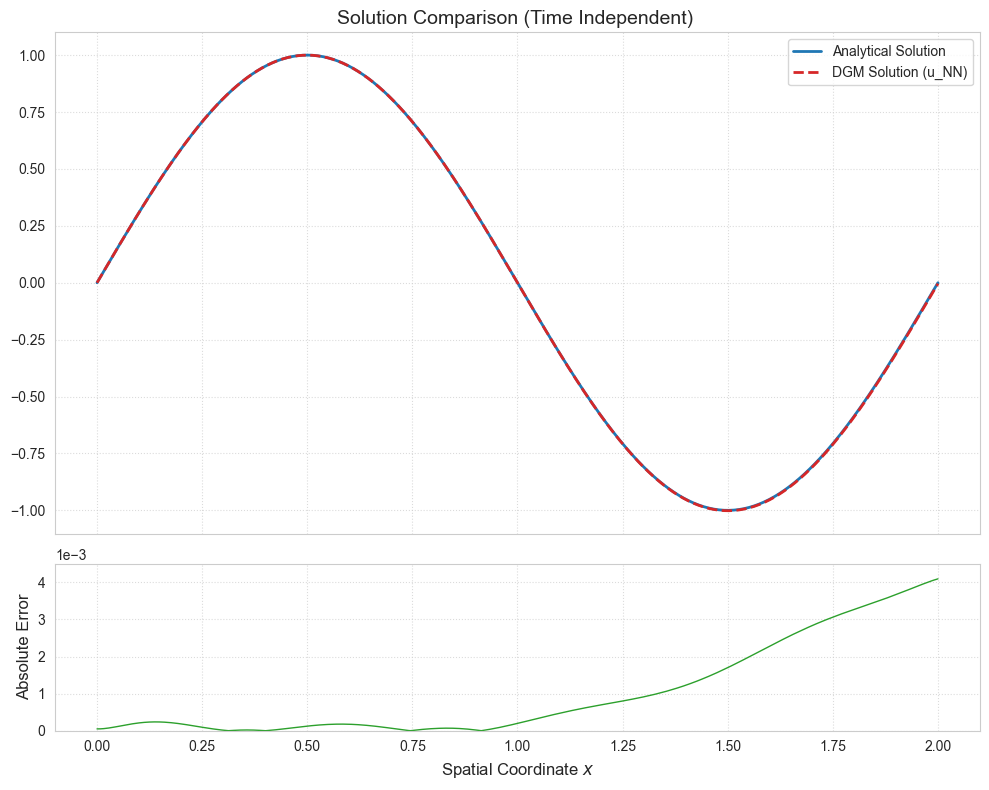

In [7]:
visualize_loss(trainer)

## Quantitative Error Analysis

In [22]:
x_test = torch.linspace(0, lx_1d, 1000).reshape(-1, 1).to(device)
error = calculate_relative_l2_error(model, x_test, analytical_function_1d)
print(f"Relative L2 Error: {error:.4e}")

## Visualization of the Solutionn

In [23]:
visualize_solution_1d(model, lx_1d,n_test_points=500)


# Deep Galerkin Method with Poisson Equation in 2D

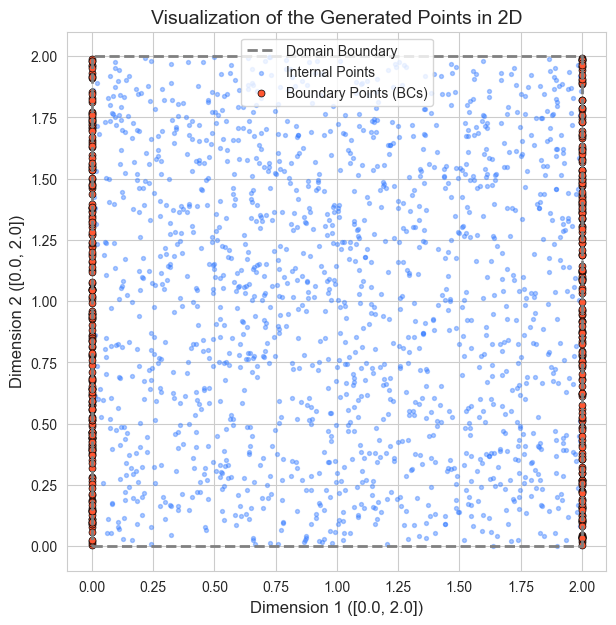

In [24]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01

# Data Sizes
N_INT = 1500
N_BC =800

## Data Preparation

In [29]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords = generate_domain_points(N_INT, bounds_2d)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_xy = source_term_fn_2d(x_int, y_int).to(device)
interior_data = (x_int, y_int,  f_xy)


# 2. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_bc_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
u_bc = boundary_condition_fn_2d(x_bc, y_bc).to(device)
bc_data = (x_bc,y_bc, u_bc)


## Visualization of the Generated Data Points

In [30]:
visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

Epoch 100/5200 | Total Loss: 2.3034 | L_pde: 0.3895 | L_bc: 0.0712
Epoch 200/5200 | Total Loss: 0.5402 | L_pde: 0.0801 | L_bc: 0.0279
Epoch 300/5200 | Total Loss: 0.2719 | L_pde: 0.0444 | L_bc: 0.0100
Epoch 400/5200 | Total Loss: 0.0780 | L_pde: 0.0122 | L_bc: 0.0034
Epoch 500/5200 | Total Loss: 0.0485 | L_pde: 0.0082 | L_bc: 0.0015
Epoch 600/5200 | Total Loss: 0.0332 | L_pde: 0.0058 | L_bc: 0.0008
Epoch 700/5200 | Total Loss: 0.0261 | L_pde: 0.0047 | L_bc: 0.0006
Epoch 800/5200 | Total Loss: 0.0214 | L_pde: 0.0038 | L_bc: 0.0005
Epoch 900/5200 | Total Loss: 0.0858 | L_pde: 0.0167 | L_bc: 0.0005
Epoch 1000/5200 | Total Loss: 0.0192 | L_pde: 0.0034 | L_bc: 0.0004
Epoch 1100/5200 | Total Loss: 0.0124 | L_pde: 0.0022 | L_bc: 0.0003
Epoch 1200/5200 | Total Loss: 0.0109 | L_pde: 0.0019 | L_bc: 0.0003
Epoch 1300/5200 | Total Loss: 0.0131 | L_pde: 0.0023 | L_bc: 0.0003
Epoch 1400/5200 | Total Loss: 0.0086 | L_pde: 0.0015 | L_bc: 0.0002
Epoch 1500/5200 | Total Loss: 0.1697 | L_pde: 0.0333 | L_

## Network Initialization

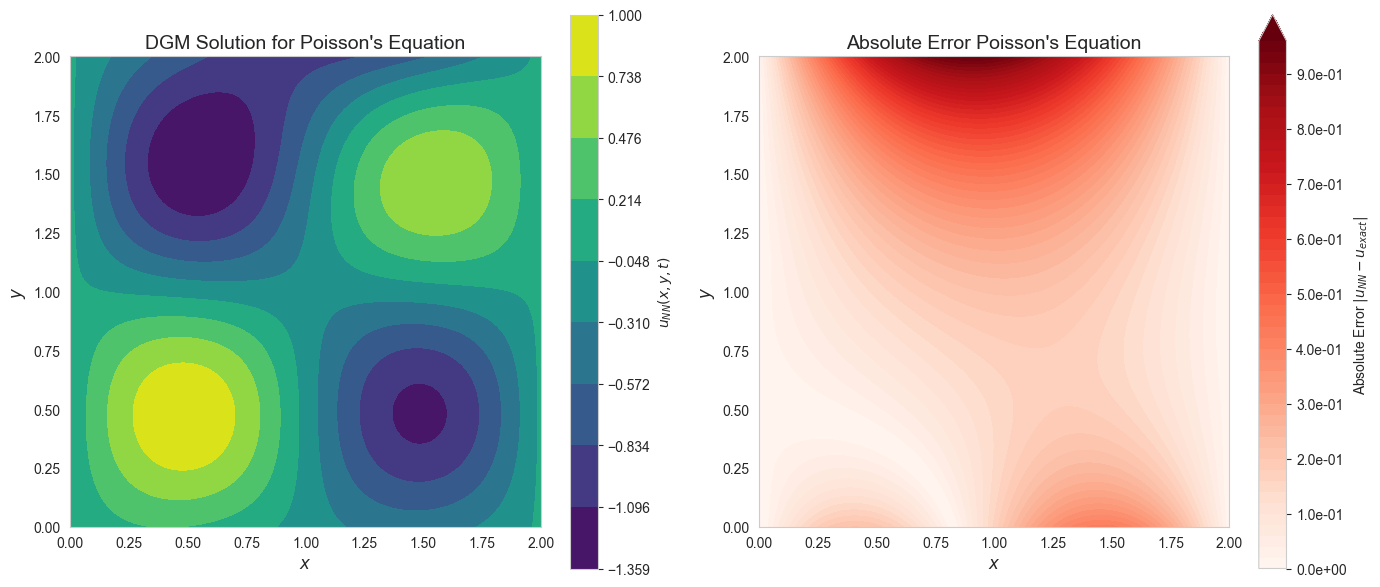

In [31]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 5200

model = network.DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainerPE_2D(
    model=model,
    learning_rate=learning_rate
)

## Training

In [ ]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data,
    bc_data=bc_data,
    lambda_pde=5.0,
    lambda_bc=5.0,
    resample=True,
    sampling_config={
        'n_int': N_INT,
        'n_bc': N_BC,
        'bounds': bounds_2d
    }
)

## Loss History

In [ ]:
visualize_loss(trainer)

## Quantitative Error Analysis

In [ ]:
x_test = torch.linspace(0, lx_2d, 100).to(device)
y_test = torch.linspace(0, ly_2d, 100).to(device)
X, Y = torch.meshgrid(x_test, y_test, indexing='ij')
x_flat = X.reshape(-1, 1)
y_flat = Y.reshape(-1, 1)
error = calculate_relative_l2_error_2d(model, x_flat, y_flat, analytical_function_2d)
print(f"Relative L2 Error: {error:.4e}")

## Visualization of the Solution

In [ ]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    n_grid=500
)

In [ ]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    n_grid=500
)